# **Classification of Sports Injuries through Biomechanical Data Analysis and Machine Learning Models**



**By:** María Emilia Aguirre

**Creation Date:** 10 / 02 / 2025

**Last Update Date:** 05 / 05 / 2025


**Universidad San Francisco de Quito**


### **1. Pipeline Description**



---


This Google Colab notebook applies an entirely
reproducible biomechanical gait-based injury classification pipeline for runners.

This notebook starts by providing details regarding dataset acquisition, importing all libraries.

The raw data were subjected to systematic preprocessing, missing-value imputation, and derivation of a binarized injury label—prior to stratified splitting within training and test subsets.
Subsequently, five supervised classifiers (Random Forest, Multilayer Perceptron, Support Vector Machine, K-Nearest Neighbors, and Gaussian Naive Bayes) were each run under 10 k-fold cross-validation, performance rigorously quantified via F1-score, accuracy, AUC, precision, recall. The important results are discussed through exhaustive tables and plots, followed by an in-depth discussion on limitations in methods and suggested future directions.


---




#### **1.1. Dataset Source:**

1.   Brett, A. et al. (2024) Running Injury Clinic Kinematic Dataset, figshare. Available at: https://plus.figshare.com/articles/dataset/Running_Injury_Clinic_Kinematic_Dataset/24255795/1 (Accessed: 22 April 2025).



#### **1.2. Key Papers:**



1.   Ferber, R. et al. (2024) A biomechanical dataset of 1,798 healthy and injured subjects during treadmill walking and running, Scientific data. Available at: https://pmc.ncbi.nlm.nih.gov/articles/PMC11564798/ (Accessed: 22 April 2025).





### **2. Environment and Dependencies**

In [1]:
# Imports

import pandas as pd
import numpy as np

# Visualization & EDA
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Scikit‑learn utilities
from sklearn.model_selection    import train_test_split, StratifiedKFold
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline           import Pipeline
from sklearn.compose            import ColumnTransformer

# Example classifier (you can swap in any model)
from sklearn.ensemble           import RandomForestClassifier

import math
from sklearn.manifold            import TSNE


In [2]:
# Python Version

!python --version

Python 3.11.12


In [3]:
# List all installed packages and their versions
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib

print("NumPy     :", np.__version__)
print("pandas    :", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)
print("matplotlib:", matplotlib.__version__)


NumPy     : 2.0.2
pandas    : 2.2.2
scikit-learn: 1.6.1
TensorFlow: 2.18.0
matplotlib: 3.10.0


#### **2.1. Verdana Font:**

In [4]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 1) Apunta al archivo Verdana.ttf que descargaste
fm.fontManager.addfont('/content/sample_data/VERDANAI.TTF')

# 3) Luego configuras Verdana como familia predeterminada
plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size']   = 16


### **3. Data Description**

In [5]:
# Format & Size

import pandas as pd

df = pd.read_csv("/content/sample_data/run_data_meta.csv")
print("Shape:", df.shape)

Shape: (1832, 26)


### **4. Exploratory Data Analysis (EDA)**

In [6]:
# Load & Initial EDA

df = pd.read_csv('/content/sample_data/run_data_meta.csv', encoding='utf-8')
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (1832, 26)


,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,InjDefn,...,SpecInjury2,Activities,Level,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces
0,100433,2010-10-05 13:22,20101005T132240.json,1.610861,53,NaN,NaN,Unknown,NaN,Training volume/intensity affected,...,NaN,"walking, horseback riding, strength training",Recreational,13.0,10k,NaN,NaN,NaN,NaN,NaN
1,100434,2010-11-17 13:22,20101117T132240.json,2.237294,51,NaN,NaN,Female,NaN,Training volume/intensity affected,...,NaN,"running, swimming",Recreational,20.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
2,100537,2012-07-03 10:25,20120703T102550.json,2.127441,255,173.1,67.6,Female,Right,2 workouts missed in a row,...,NaN,"hiking, power walking, pilates",Recreational,2.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
3,100560,2012-07-17 10:37,20120717T103748.json,2.657365,33,179.3,83.0,Female,Right,No injury,...,NaN,Yoga,Recreational,NaN,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
4,101481,2012-07-17 10:50,20120717T105021.json,2.625088,32,176.3,58.6,Female,NaN,No injury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop non‑predictive IDs

df = df.drop(columns=["sub_id", "filename", "datestring"])

# Drop missing target & quick impute

target_col = 'InjDefn'
feature_cols = df.columns.drop(target_col)

# 3a. Drop any rows where the target is NaN
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 3b. Quick‐impute so stratify+split won’t fail
num_cols = df[feature_cols].select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df[feature_cols].select_dtypes(include=['object','category']).columns.tolist()

# median‐impute numerics
df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])
# constant‐impute categoricals
df[cat_cols] = df[cat_cols].fillna('MISSING')

In [8]:
# Quick overview of missing data
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 speed_r         0
age             0
Height          0
Weight          0
Gender          0
DominantLeg     0
InjDefn         0
InjJoint        0
InjSide         0
SpecInjury      0
InjDuration     0
InjJoint2       0
InjSide2        0
SpecInjury2     0
Activities      0
Level           0
YrsRunning      0
RaceDistance    0
RaceTimeHrs     0
RaceTimeMins    0
RaceTimeSecs    0
YrPR            0
NumRaces        0
dtype: int64


### **5. Cleaning and Preprocessing**

In [9]:
# Convert time columns to numeric
time_cols = ['RaceTimeHrs', 'RaceTimeMins', 'RaceTimeSecs']
df[time_cols] = df[time_cols].apply(pd.to_numeric, errors='coerce')

# Normalize 'Unknown' → NaN
df.replace('Unknown', np.nan, inplace=True)

# Identify feature types
numeric_cols     = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("\n=== Feature Types ===")
print(f"• Numeric columns   : {', '.join(numeric_cols)}")
print(f"• Categorical columns: {', '.join(categorical_cols)}")

# Drop duplicates (if any)
dupe_count = df.duplicated().sum()
if dupe_count:
    df.drop_duplicates(inplace=True)
    print(f"\nDropped {dupe_count} duplicate rows. New shape: {df.shape}")

# One‑Hot encode & MinMax‑scale
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_processed[numeric_cols] = MinMaxScaler().fit_transform(df_processed[numeric_cols])

print("\n=== Processed Dataset Preview ===")
print(df_processed.head().to_string(index=False))

# Top categories summary
print("\n=== Top 5 Values per Categorical Column ===")
for col in categorical_cols:
    vc = df[col].value_counts()
    top5 = vc.head(5)
    print(f"\n{col} ({vc.size} uniques):")
    for val, cnt in top5.items():
        print(f"  - {val}: {cnt}")


=== Feature Types ===
• Numeric columns   : speed_r, age, Height, Weight, InjDuration, YrsRunning, RaceTimeHrs, RaceTimeMins, RaceTimeSecs, YrPR, NumRaces
• Categorical columns: Gender, DominantLeg, InjDefn, InjJoint, InjSide, SpecInjury, InjJoint2, InjSide2, SpecInjury2, Activities, Level, RaceDistance

=== Processed Dataset Preview ===
 speed_r      age   Height   Weight  InjDuration  YrsRunning  RaceTimeHrs  RaceTimeMins  RaceTimeSecs     YrPR  NumRaces  Gender_Male  DominantLeg_Left  DominantLeg_MISSING  DominantLeg_Right  InjDefn_Continuing to train in pain  InjDefn_No injury  InjDefn_Training volume/intensity affected  InjJoint_Foot  InjJoint_Hip/Pelvis  InjJoint_Knee  InjJoint_Lower Leg  InjJoint_Lumbar Spine  InjJoint_MISSING  InjJoint_No Injury  InjJoint_No injury,No injury  InjJoint_Other  InjJoint_Sacroiliac Joint  InjJoint_Thigh  InjSide_Left  InjSide_MISSING  InjSide_Right  SpecInjury_Bursitis  SpecInjury_Calf muscle strain  SpecInjury_Chondromalacia  SpecInjury_Compartme

In [10]:
# Convert time cols & normalize Unknown
time_cols = ['RaceTimeHrs','RaceTimeMins','RaceTimeSecs']
df[time_cols] = df[time_cols].apply(pd.to_numeric, errors='coerce')
df.replace('Unknown', np.nan, inplace=True)

# Identify types
numeric_cols     = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Feature summary table
feat_df = pd.DataFrame({
    'feature': numeric_cols + categorical_cols,
    'type':    ['numeric'] * len(numeric_cols) + ['categorical'] * len(categorical_cols)
})
print("\n## Feature Types")
print(feat_df.to_markdown(index=False))

# Duplicates check
dupes = df.duplicated().sum()
if dupes:
    df.drop_duplicates(inplace=True)
    print(f"\nDropped **{dupes}** duplicate rows; new shape **{df.shape}**.")

# One‑Hot + MinMax
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_processed[numeric_cols] = MinMaxScaler().fit_transform(df_processed[numeric_cols])

# Preview
print("\n## Processed Data (first 5 rows)")
print(df_processed.head().to_markdown(index=False))

# Categorical summary table
cat_summary = []
for col in categorical_cols:
    vc = df[col].value_counts().head(3)
    cat_summary.append({
        'column':      col,
        'uniques':     df[col].nunique(),
        'top_3_vals':  ', '.join(vc.index.astype(str)),
        'top_3_counts': ', '.join(vc.astype(str))
    })

cat_df = pd.DataFrame(cat_summary)
print("\n## Categorical Variables Summary")
print(cat_df.to_markdown(index=False))


## Feature Types
| feature      | type        |
|:-------------|:------------|
| speed_r      | numeric     |
| age          | numeric     |
| Height       | numeric     |
| Weight       | numeric     |
| InjDuration  | numeric     |
| YrsRunning   | numeric     |
| RaceTimeHrs  | numeric     |
| RaceTimeMins | numeric     |
| RaceTimeSecs | numeric     |
| YrPR         | numeric     |
| NumRaces     | numeric     |
| Gender       | categorical |
| DominantLeg  | categorical |
| InjDefn      | categorical |
| InjJoint     | categorical |
| InjSide      | categorical |
| SpecInjury   | categorical |
| InjJoint2    | categorical |
| InjSide2     | categorical |
| SpecInjury2  | categorical |
| Activities   | categorical |
| Level        | categorical |
| RaceDistance | categorical |

## Processed Data (first 5 rows)
|   speed_r |       age |   Height |    Weight |   InjDuration |   YrsRunning |   RaceTimeHrs |   RaceTimeMins |   RaceTimeSecs |     YrPR |   NumRaces | Gender_Male   | Dom

## **6. Visualization**

### **6.1. Histogram**

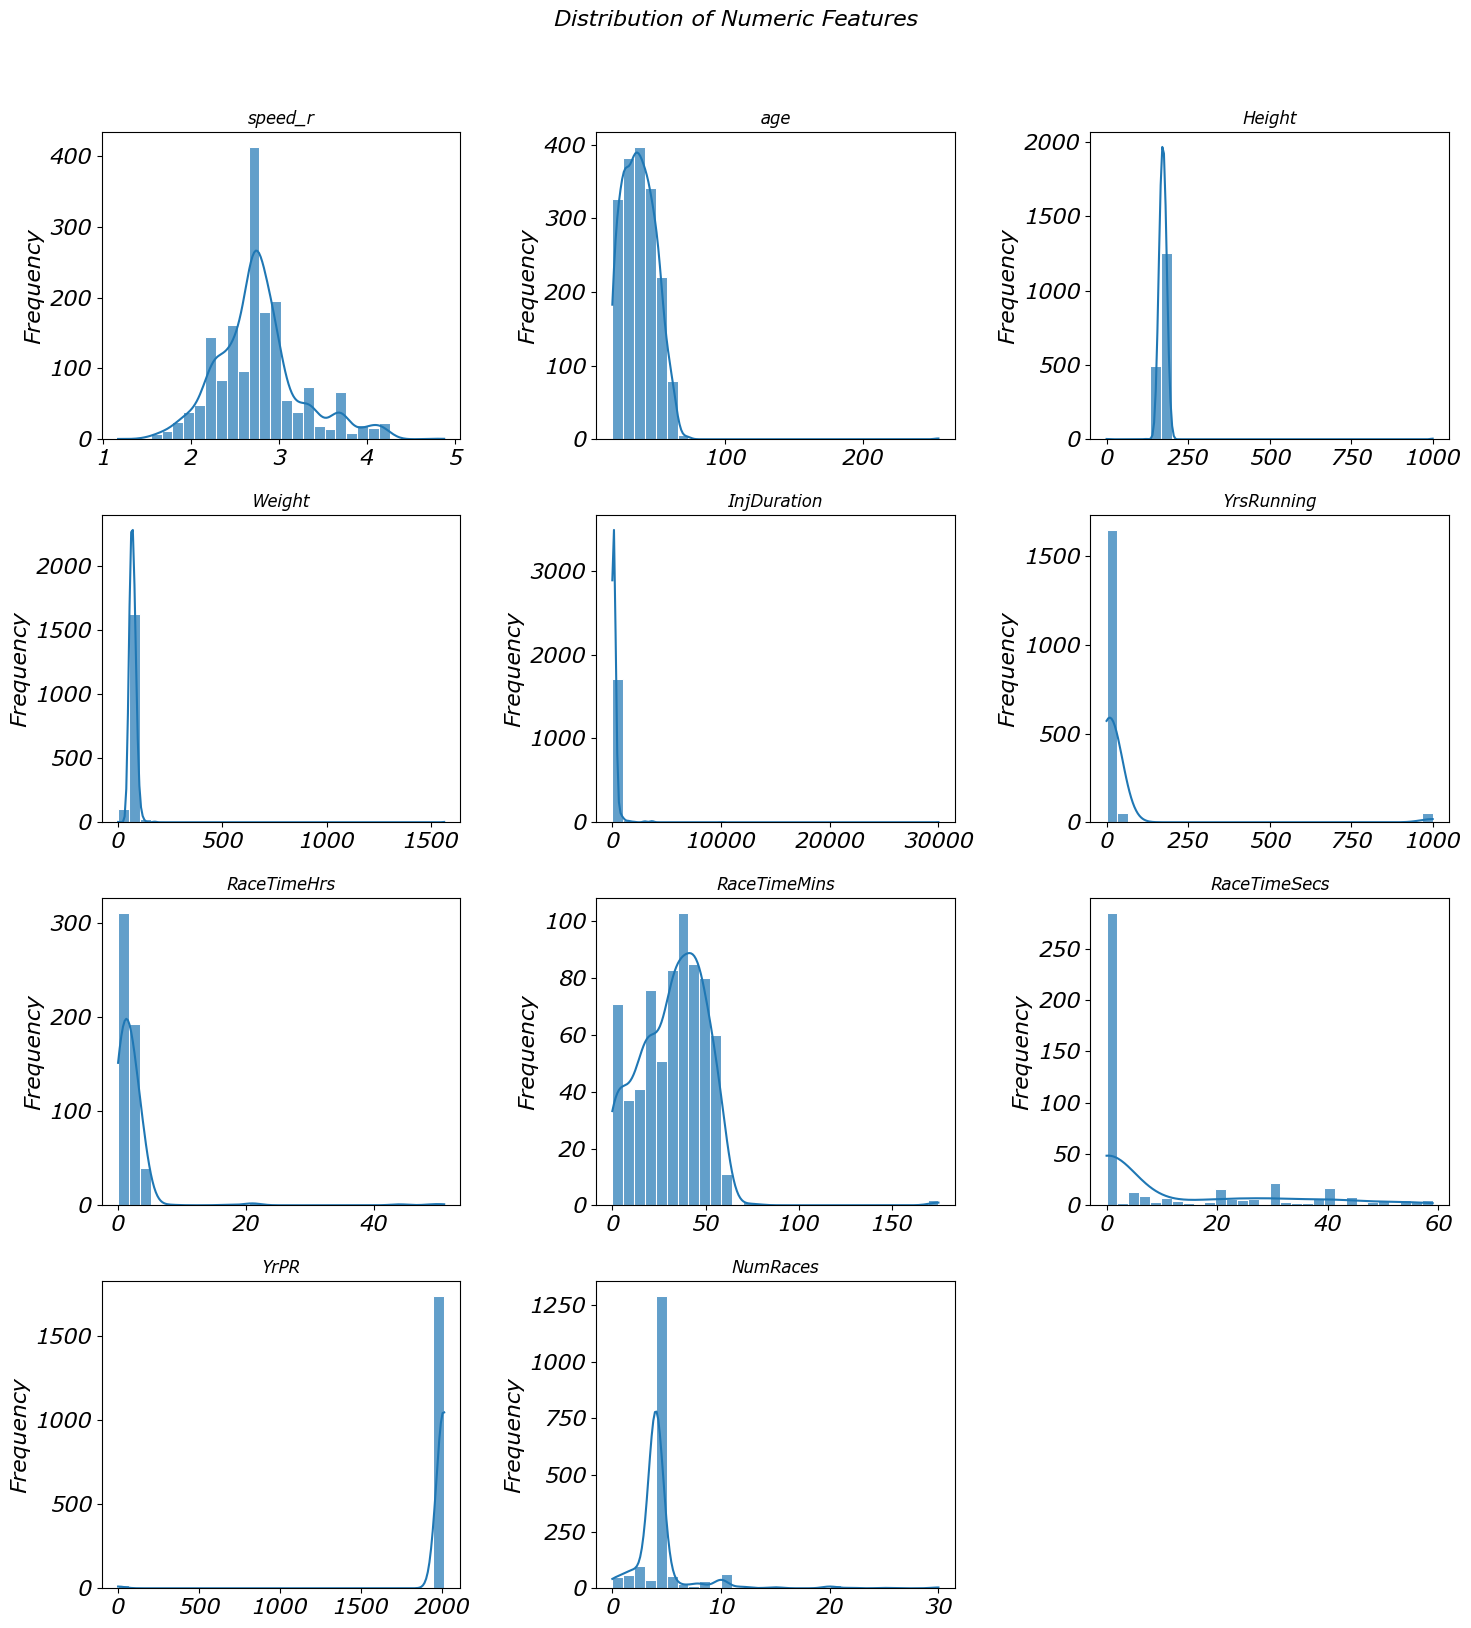

In [11]:
# Grab all numeric columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
n = len(numeric_cols)

# Grid
ncols = 3
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
axes = axes.flatten()

# Loop and plot
for ax, col in zip(axes, numeric_cols):
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        ax=ax,
        binwidth=(df[col].max() - df[col].min()) / 30,  # ~30 bins
        edgecolor='w',
        alpha=0.7
    )
    ax.set_title(col, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

# Turn off any leftover axes
for ax in axes[n:]:
    ax.set_visible(False)

plt.suptitle("Distribution of Numeric Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### **6.2. Pearson Correlation Matrix**

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Verdana.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Verdana.
  fig.canvas.print_figure(bytes_io, **kw)


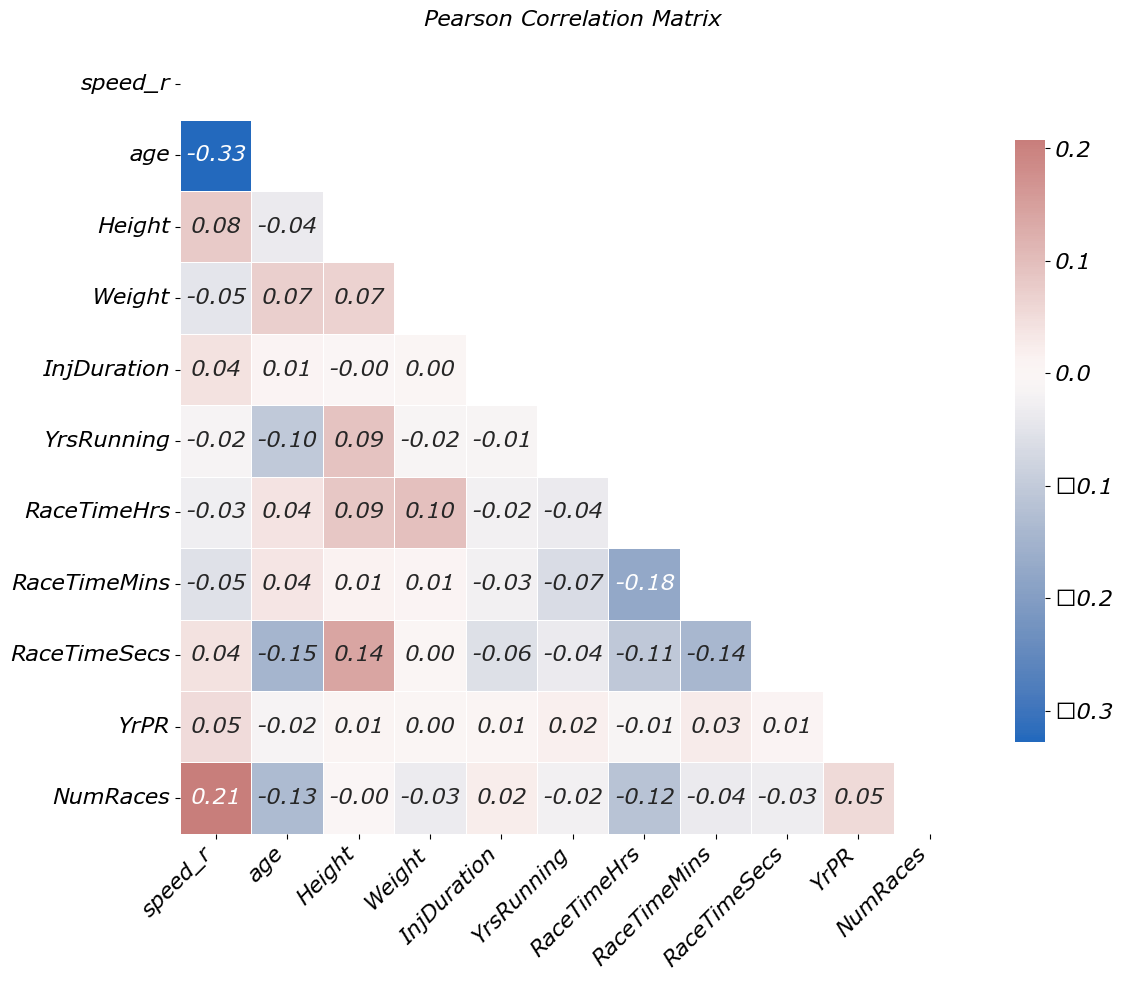

In [12]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

# Ticks and title formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title("Pearson Correlation Matrix", fontsize=16, pad=16)

plt.tight_layout()
plt.show()


In [13]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Compute and apply IQR capping, collect stats
rows = []
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR    = Q3 - Q1
    lower  = Q1 - 1.5 * IQR
    upper  = Q3 + 1.5 * IQR

    # count how many will be capped
    n_low  = (df[col] < lower).sum()
    n_high = (df[col] > upper).sum()

    # cap in one call
    df[col] = df[col].clip(lower, upper)

    rows.append({
        'column':        col,
        'Q1':            Q1,
        'Q3':            Q3,
        'lower_bound':   lower,
        'upper_bound':   upper,
        'capped_low':    n_low,
        'capped_high':   n_high
    })

# Show summary as a neat table
summary_df = pd.DataFrame(rows)
print("\nOutlier capping summary:")
print(
    summary_df
    .loc[:, ['column','lower_bound','upper_bound','capped_low','capped_high']]
    .to_string(index=False)
)


Outlier capping summary:
      column  lower_bound  upper_bound  capped_low  capped_high
     speed_r     1.791227     3.634929          23          139
         age     1.000000    73.000000           0            1
      Height   144.500000   199.700000           3            2
      Weight    32.700000   105.500000           1           22
 InjDuration   120.000000   120.000000         193          198
  YrsRunning    -7.000000    25.000000           0          177
 RaceTimeHrs    -2.000000     6.000000           0           11
RaceTimeMins   -20.000000    84.000000           0            2
RaceTimeSecs   -30.000000    50.000000           0           17
        YrPR  2012.000000  2012.000000         100           50
    NumRaces     4.000000     4.000000         241          221


In [14]:
# Final overview of the preprocessed dataset
print("\n=== Preprocessed Dataset Overview ===")

# a) Shape
rows, cols = df.shape
print(f"• Shape: {rows} rows × {cols} columns")

# b) Data types
dtypes = df.dtypes.reset_index()
dtypes.columns = ['column', 'dtype']
print("\n• Column dtypes:")
print(dtypes.to_markdown(index=False))

# c) Missing values
missing = df.isnull().sum().reset_index()
missing.columns = ['column', 'missing_count']
print("\n• Missing values per column:")
print(missing.to_markdown(index=False))

# d) Sample rows
print("\n• First 5 rows:")
print(df.head().to_markdown(index=False))



=== Preprocessed Dataset Overview ===
• Shape: 1752 rows × 23 columns

• Column dtypes:
| column       | dtype   |
|:-------------|:--------|
| speed_r      | float64 |
| age          | float64 |
| Height       | float64 |
| Weight       | float64 |
| Gender       | object  |
| DominantLeg  | object  |
| InjDefn      | object  |
| InjJoint     | object  |
| InjSide      | object  |
| SpecInjury   | object  |
| InjDuration  | float64 |
| InjJoint2    | object  |
| InjSide2     | object  |
| SpecInjury2  | object  |
| Activities   | object  |
| Level        | object  |
| YrsRunning   | float64 |
| RaceDistance | object  |
| RaceTimeHrs  | float64 |
| RaceTimeMins | float64 |
| RaceTimeSecs | float64 |
| YrPR         | float64 |
| NumRaces     | float64 |

• Missing values per column:
| column       |   missing_count |
|:-------------|----------------:|
| speed_r      |               0 |
| age          |               0 |
| Height       |               0 |
| Weight       |               

In [15]:
# Check existence
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in DataFrame.")

# Vectorized cleaning pipeline
cleaned = (
    df['InjDefn']
      .astype(str)                        # ensure string
      .str.strip()                        # trim whitespace
      .str.lower()                        # unify case
      .str.replace(r'[^\w\s]', '', regex=True)  # drop punctuation
      .replace({'nan': pd.NA})           # turn literal "nan" back to NA
)

df['InjDefn'] = cleaned

# Report
summary = (
    df['InjDefn']
      .value_counts(dropna=False)
      .rename_axis('cleaned_value')
      .reset_index(name='count')
)

print("\n‘InjDefn’ cleaning complete.  Summary of cleaned values:")
print(summary.to_markdown(index=False))


‘InjDefn’ cleaning complete.  Summary of cleaned values:
| cleaned_value                     |   count |
|:----------------------------------|--------:|
| no injury                         |     659 |
| training volumeintensity affected |     499 |
| continuing to train in pain       |     320 |
| 2 workouts missed in a row        |     274 |


## **7. Binarization of "InjDefn"**

<ipython-input-16-51b610a76ae6>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



'InjDefn' Distribution Before Binarization
| Label                             |   Frequency |
|:----------------------------------|------------:|
| no injury                         |         659 |
| training volumeintensity affected |         499 |
| continuing to train in pain       |         320 |
| 2 workouts missed in a row        |         274 |


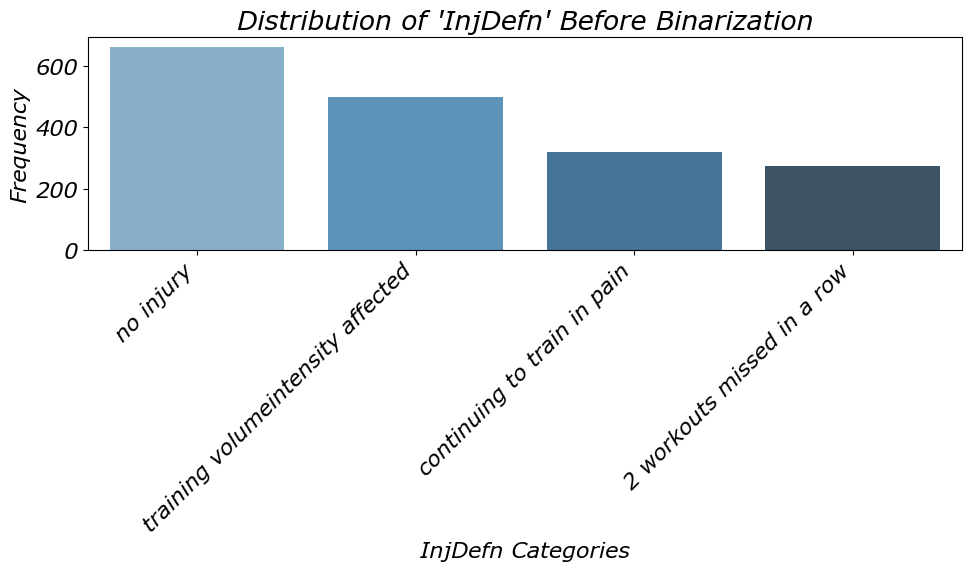

In [16]:
# Verify that the 'InjDefn' column exists
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in the DataFrame.")

# Vectorized cleaning: trim whitespace, lowercase, remove punctuation
df['InjDefn'] = (
    df['InjDefn']
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r'[^\w\s]', '', regex=True)
        .replace({'nan': pd.NA})
)

# Build frequency table (including NaNs)
freq_table = (
    df['InjDefn']
        .value_counts(dropna=False)
        .rename_axis('Label')
        .reset_index(name='Frequency')
)

print("\n'InjDefn' Distribution Before Binarization")
print(freq_table.to_markdown(index=False))

# Plot the distribution with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=freq_table,
    x='Label',
    y='Frequency',
    palette='Blues_d'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("InjDefn Categories")
plt.ylabel("Frequency")
plt.title("Distribution of 'InjDefn' Before Binarization")
plt.tight_layout()
plt.show()



InjDefn_binary Distribution:
|   Injury |   Count |
|---------:|--------:|
|        0 |     659 |
|        1 |    1093 |


<ipython-input-17-16982409b481>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='InjDefn_binary', data=df, palette='vlag', edgecolor='k')


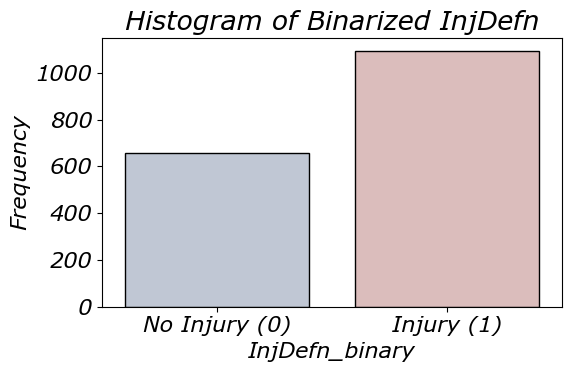

In [17]:
# Verify column exists
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in DataFrame.")

# Clean & normalize text
clean = (
    df['InjDefn']
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r'[^\w\s]', '', regex=True)  # drop punctuation
)
clean = clean.replace('nan', pd.NA).fillna('none')
df['InjDefn'] = clean

# Define “no‑injury” labels and binarize
no_injury = {'none', 'no lesion', 'no injury', ''}
df['InjDefn_binary'] = (~clean.isin(no_injury)).astype(int)

# Print distribution as a table
dist = df['InjDefn_binary'].value_counts().sort_index().rename_axis('Injury').reset_index(name='Count')
print("\nInjDefn_binary Distribution:")
print(dist.to_markdown(index=False))

# Plot it with seaborn
plt.figure(figsize=(6, 4))
sns.countplot(x='InjDefn_binary', data=df, palette='vlag', edgecolor='k')
plt.xticks([0,1], ['No Injury (0)', 'Injury (1)'])
plt.xlabel("InjDefn_binary")
plt.ylabel("Frequency")
plt.title("Histogram of Binarized InjDefn")
plt.tight_layout()
plt.show()

### **7.1. Boxplots**

<ipython-input-18-c988365b93ab>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


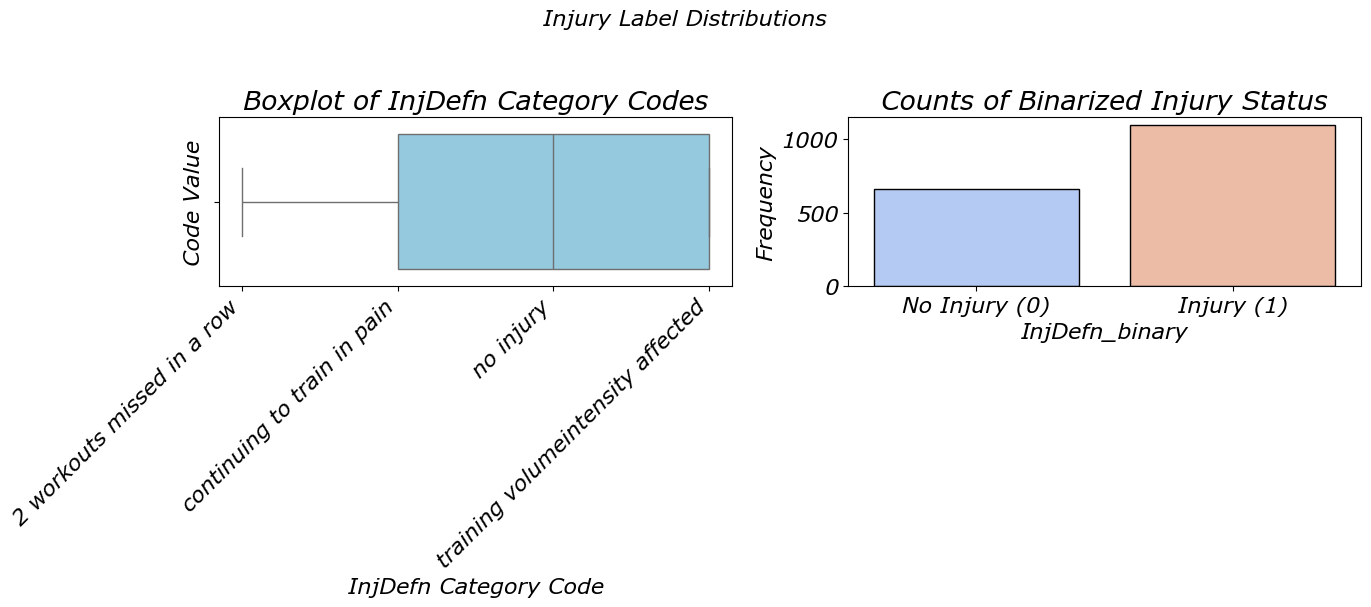

In [18]:
# Convert 'InjDefn' to ordered categorical codes once
df['InjDefn_cat'] = df['InjDefn'].astype('category')
df['InjDefn_code'] = df['InjDefn_cat'].cat.codes

# Prepare figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Boxplot of the category codes
sns.boxplot(
    x='InjDefn_code',
    data=df,
    ax=ax1,
    color='skyblue'
)
ax1.set_title('Boxplot of InjDefn Category Codes')
ax1.set_xlabel('InjDefn Category Code')
ax1.set_ylabel('Code Value')

# Map tick labels back to category names
labels = df['InjDefn_cat'].cat.categories.to_list()
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right')

# Countplot for the binary variable (more meaningful than a boxplot)
sns.countplot(
    x='InjDefn_binary',
    data=df,
    ax=ax2,
    palette='coolwarm',
    edgecolor='k'
)
ax2.set_title('Counts of Binarized Injury Status')
ax2.set_xlabel('InjDefn_binary')
ax2.set_ylabel('Frequency')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['No Injury (0)', 'Injury (1)'])

# Final layout tweaks
plt.suptitle('Injury Label Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


InjDefn category-to-code mapping:
| Category                          |   Code |
|:----------------------------------|-------:|
| 2 workouts missed in a row        |      0 |
| continuing to train in pain       |      1 |
| no injury                         |      2 |
| training volumeintensity affected |      3 |

Code distribution:
|   Code |   Count |
|-------:|--------:|
|      0 |     274 |
|      1 |     320 |
|      2 |     659 |
|      3 |     499 |


<ipython-input-19-8e6f19d24ee2>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


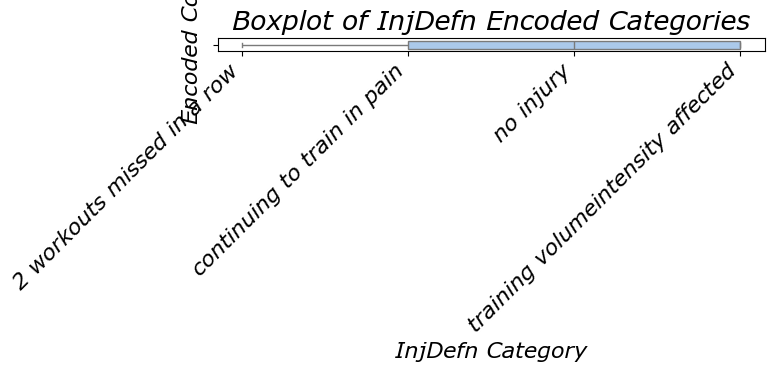

In [19]:
# Verify column exists
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in DataFrame.")

# Clean and categorize
df['InjDefn_clean'] = (
    df['InjDefn']
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r'[^\w\s]', '', regex=True)
)
df['InjDefn_cat'] = df['InjDefn_clean'].astype('category')
df['InjDefn_code'] = df['InjDefn_cat'].cat.codes

# Print mapping table
mapping = pd.DataFrame({
    'Category': df['InjDefn_cat'].cat.categories,
    'Code':     range(len(df['InjDefn_cat'].cat.categories))
})
print("\nInjDefn category-to-code mapping:")
print(mapping.to_markdown(index=False))

# Summary of code distribution
code_dist = (
    df['InjDefn_code']
      .value_counts()
      .sort_index()
      .rename_axis('Code')
      .reset_index(name='Count')
)
print("\nCode distribution:")
print(code_dist.to_markdown(index=False))

# Boxplot of codes
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    x='InjDefn_code',
    data=df,
    ax=ax,
    palette='pastel',
    width=0.6
)
ax.set_xticks(mapping['Code'])
ax.set_xticklabels(mapping['Category'], rotation=45, ha='right')
ax.set_xlabel("InjDefn Category")
ax.set_ylabel("Encoded Code")
ax.set_title("Boxplot of InjDefn Encoded Categories")
plt.tight_layout()
plt.show()


### **7.2. Visualización t-SNE**


Missing values by feature:
| feature      |   missing_count |
|:-------------|----------------:|
| speed_r      |               0 |
| age          |               0 |
| Height       |               0 |
| Weight       |               0 |
| InjDuration  |               0 |
| YrsRunning   |               0 |
| RaceTimeHrs  |            1197 |
| RaceTimeMins |            1051 |
| RaceTimeSecs |            1307 |
| YrPR         |               0 |
| NumRaces     |               0 |
| InjDefn_code |               0 |


<ipython-input-20-00ed72a9b155>:55: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Verdana.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Verdana.
  fig.canvas.print_figure(bytes_io, **kw)


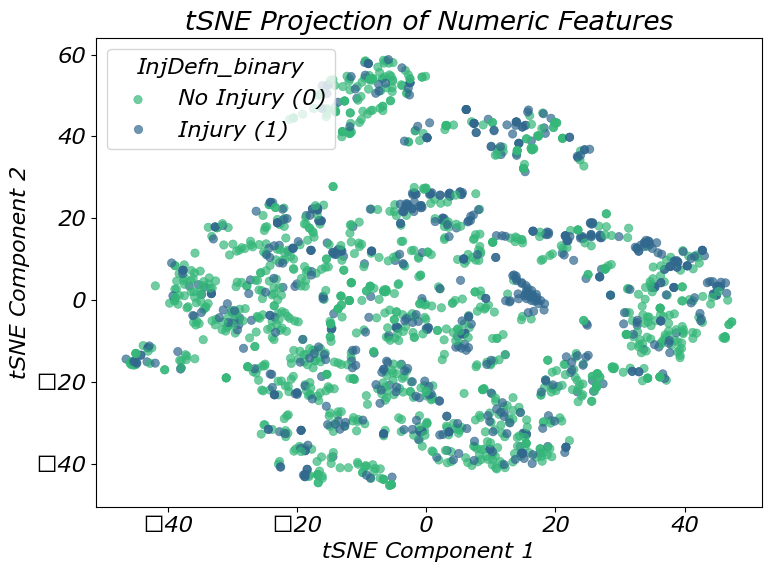

In [20]:
# Select numeric features (drop the binary target)
numeric_cols = (
    df
    .select_dtypes(include=[np.number])
    .columns
    .drop('InjDefn_binary', errors='ignore')
)
X_num = df[numeric_cols]

# Summarize missing values
missing = (
    X_num.isnull()
         .sum()
         .reset_index()
         .rename(columns={'index': 'feature', 0: 'missing_count'})
)
print("\nMissing values by feature:")
print(missing.to_markdown(index=False))

# Impute missing values (mean strategy)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X_num), columns=numeric_cols)

# Compute t‑SNE embedding (no PCA step)
tsne = TSNE(
    n_components=2,
    init='random',
    learning_rate='auto',
    perplexity=30,
    random_state=42
)
tsne_results = tsne.fit_transform(X_imputed)

# Attach t‑SNE coordinates back to the DataFrame
df['TSNE_1'], df['TSNE_2'] = tsne_results[:, 0], tsne_results[:, 1]

# Plot the t‑SNE projection
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE_1', y='TSNE_2',
    hue='InjDefn_binary',
    data=df,
    palette='viridis',
    alpha=0.7,
    edgecolor=None
)
plt.title('tSNE Projection of Numeric Features')
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.legend(
    title='InjDefn_binary',
    labels=['No Injury (0)', 'Injury (1)'],
    loc='best'
)
plt.tight_layout()
plt.show()

## **8. Shallow Learning Models**

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_predict, StratifiedKFold,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, precision_score, recall_score, f1_score
)
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np

In [22]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=r"Found unknown categories in columns",
    category=UserWarning,
    module="sklearn.preprocessing._encoders"
)

In [23]:
X = df.drop(columns=['InjDefn', 'InjDefn_binary','InjDefn_cat','InjDefn_code','InjDefn_clean'], errors='ignore')
y = df['InjDefn_binary']

# Detect numeric vs categorical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Build preprocessing transformer
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])


# Stratified 70-30 train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)


# After the transformation
X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

# Ensure they are NumPy arrays (not sparse matrices)
if not isinstance(X_train, np.ndarray):
    X_train = X_train.toarray()

if not isinstance(X_test, np.ndarray):
    X_test = X_test.toarray()

# Also convert y_train and y_test to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Report final input dimension
input_dim = X_train.shape[1]
print(f"Input dimension after one-hot, imputation and scaling: {input_dim}")


Input dimension after one-hot, imputation and scaling: 772


In [24]:
X.columns

Index(['speed_r', 'age', 'Height', 'Weight', 'Gender', 'DominantLeg',
       'InjJoint', 'InjSide', 'SpecInjury', 'InjDuration', 'InjJoint2',
       'InjSide2', 'SpecInjury2', 'Activities', 'Level', 'YrsRunning',
       'RaceDistance', 'RaceTimeHrs', 'RaceTimeMins', 'RaceTimeSecs', 'YrPR',
       'NumRaces', 'TSNE_1', 'TSNE_2'],
      dtype='object')

In [25]:
def train_test_model(model, X_train, y_train, X_test, y_test, title):
    print("=" * 50)
    fold_acc, fold_auc, fold_prec, fold_rec, fold_f1 = [], [], [], [], []
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        auc_ = roc_auc_score(y_val, y_proba)
        pre = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        fold_acc.append(acc)
        fold_auc.append(auc_)
        fold_prec.append(pre)
        fold_rec.append(rec)
        fold_f1.append(f1)

        print(f"\nFold {fold}")
        print(classification_report(y_val, y_pred, zero_division=0))
        print(f"Accuracy : {acc:.4f}")
        print(f"AUC      : {auc_:.4f}")
        print(f"Precision: {pre:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1       : {f1:.4f}")
        print("-" * 50)

    # Summary (mean ± SD)
    summary_svm = pd.DataFrame({
        "Metric": ["Mean Accuracy", "Mean AUC", "Mean Precision", "Mean Recall", "Mean F1"],
        "Mean":   [np.mean(fold_acc), np.mean(fold_auc), np.mean(fold_prec), np.mean(fold_rec), np.mean(fold_f1)],
        "±":      [np.std(fold_acc, ddof=1), np.std(fold_auc, ddof=1), np.std(fold_prec, ddof=1), np.std(fold_rec, ddof=1), np.std(fold_f1, ddof=1)]
    })

    print(f"\nSummary table of average metrics (10-Fold CV, {title}):")
    print(summary_svm.to_string(index=False, formatters={
        "Mean": "{:.6f}".format,
        "±":    "{:.6f}".format
    }))

    # Final model on full training set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nTest-set classification report ({title}):")
    print(classification_report(y_test, y_test_pred, zero_division=0))
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test AUC     : {roc_auc_score(y_test, y_test_proba):.4f}")

    # Compute hold-out metrics
    test_metrics = {
        'accuracy':  accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall':    recall_score(y_test, y_test_pred, zero_division=0),
        'roc_auc':   roc_auc_score(y_test, y_test_proba),
        'f1':        f1_score(y_test, y_test_pred, zero_division=0)
    }

    # Build and print the DataFrame
    test_avg_metrics_df = pd.DataFrame([
        {"Metric": m.capitalize(), "Mean": test_metrics[m], "±": 0.0}
        for m in test_metrics
    ])
    print(f"\nSummary table of metrics on test set (hold-out, {title}):")
    print(test_avg_metrics_df.to_string(
        index=False,
        formatters={"Mean": "{:.6f}".format, "±": "{:.6f}".format}
    ))

    # New: Print hold-out test metrics in a neat table
    test_metrics_df = pd.DataFrame([
        {"Metric": "Accuracy",  "Value": test_metrics['accuracy']},
        {"Metric": "Precision", "Value": test_metrics['precision']},
        {"Metric": "Recall",    "Value": test_metrics['recall']},
        {"Metric": "ROC AUC",   "Value": test_metrics['roc_auc']},
        {"Metric": "F1 Score",  "Value": test_metrics['f1']}
    ])
    print(f"\nHold-out Test Set Metrics (30%):")
    print(test_metrics_df.to_string(index=False, formatters={"Value": "{:.4f}".format}))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix ({title})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({title})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'model': model,
        'fold_acc': fold_acc,
        'fold_auc': fold_auc,
        'fold_prec': fold_prec,
        'fold_rec': fold_rec,
        'fold_f1': fold_f1,
    }


In [26]:
def train_test_model2(model, n_splits, X_train, X_test, y_train, y_test, title):
    print("=" * 50)
    print(f"Cross-validation results for: {title}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scoring = {
        'accuracy':  'accuracy',
        'precision': 'precision',
        'recall':    'recall',
        'roc_auc':   'roc_auc',
        'f1':        'f1'
    }

    # Run cross-validation and capture results on training data
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring=scoring
    )

    # Results for each fold
    folds_df = pd.DataFrame({
        "Fold":      np.arange(1, len(cv_results['test_accuracy']) + 1),
        "Accuracy":  cv_results['test_accuracy'],
        "Precision": cv_results['test_precision'],
        "Recall":    cv_results['test_recall'],
        "AUC":       cv_results['test_roc_auc'],
        "F1":        cv_results['test_f1']
    })
    print("Results for each fold:")
    print(folds_df)

    # Compute mean and standard deviation
    metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
    avg_metrics_df = pd.DataFrame({
        "Metric": [m.capitalize() for m in metrics],
        "Mean": [np.mean(cv_results[f'test_{m}']) for m in metrics],
        "SD": [np.std(cv_results[f'test_{m}'], ddof=1) for m in metrics]
    })

    print("\nAverage metrics table (± sample SD):")
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        print(avg_metrics_df)

    # Predict using cross_val_predict (on training data)
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=skf)

    print("\nClassification Report (CV on training data):")
    print(classification_report(y_train, y_pred_cv))

    cm = confusion_matrix(y_train, y_pred_cv)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix – CV ({n_splits} folds) for {title}")
    plt.show()

    # ROC Curve (ensure model supports predict_proba)
    try:
        y_proba_cv = cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_proba_cv)
        roc_auc_value = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Chance')
        plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc_value:.4f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve – {title} CV ({n_splits} folds)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
    except AttributeError:
        print("Model does not support `predict_proba`; skipping ROC curve.")

    # Optional: Evaluate on test set (after training on full train set)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    print("\nTest set evaluation:")
    print(classification_report(y_test, y_test_pred))


### **8.1. Random Forest**

#### **8.1.1 Random Forest with 75**

##### **Architecture:**


---

The 75-tree Random Forest comprises 75 independent decision trees, each trained on a bootstrap sample. Splits are determined by minimizing Gini impurity, with √(p) randomly selected features considered at each node, introducing feature-level randomness. Trees are grown to full depth, halting only when leaves are pure or contain fewer than two samples, enabling them to model complex patterns. During inference, each tree produces class probabilities, which are averaged to assign the final label—reducing variance via majority voting.


Fold 1
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.99      1.00      0.99        76

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123

Accuracy : 0.9919
AUC      : 0.9994
Precision: 0.9870
Recall   : 1.0000
F1       : 0.9935
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        46
           1       0.96      1.00      0.98        77

    accuracy                           0.98       123
   macro avg       0.98      0.97      0.97       123
weighted avg       0.98      0.98      0.98       123

Accuracy : 0.9756
AUC      : 0.9951
Precision: 0.9625
Recall   : 1.0000
F1       : 0.9809
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

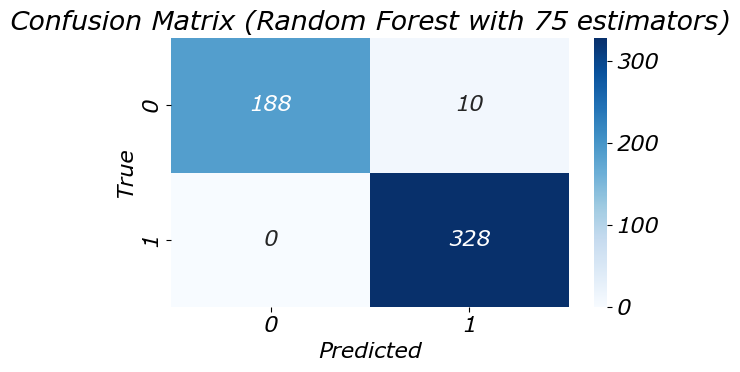

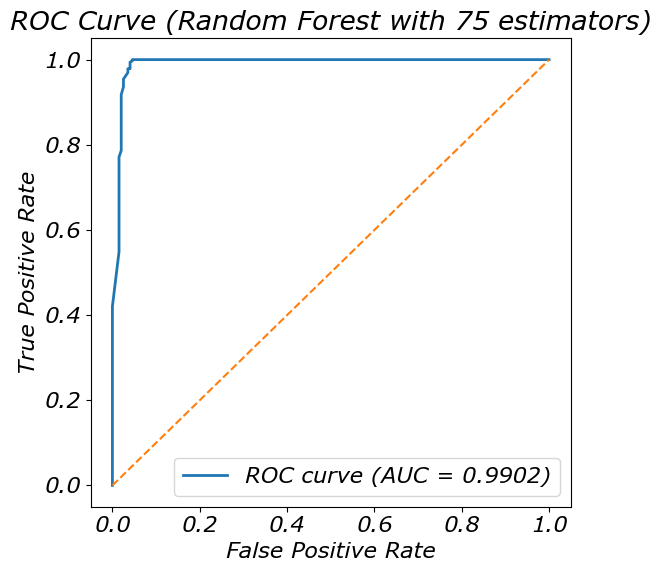

In [27]:
# Stratified 10‑fold CV – 75 estimators
n_estimators = 75

model = RandomForestClassifier(n_estimators=75, random_state=42)
title = "Random Forest with 75 estimators"
rf75 = train_test_model(model,X_train, y_train, X_test, y_test,title)

#### **8.1.2. Random Forest with 100**

##### **Architecture:**


---

The 100-tree Random Forest uses identical hyperparameters but expands the ensemble to 100 trees. This increase typically enhances generalization by reducing noise through a larger, more diverse ensemble. The benefits come at a proportional cost in training time, memory usage, and inference latency, though these remain manageable for standard tabular datasets.


Fold 1
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.99      1.00      0.99        76

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123

Accuracy : 0.9919
AUC      : 0.9994
Precision: 0.9870
Recall   : 1.0000
F1       : 0.9935
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        46
           1       0.96      1.00      0.98        77

    accuracy                           0.98       123
   macro avg       0.98      0.97      0.97       123
weighted avg       0.98      0.98      0.98       123

Accuracy : 0.9756
AUC      : 0.9955
Precision: 0.9625
Recall   : 1.0000
F1       : 0.9809
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

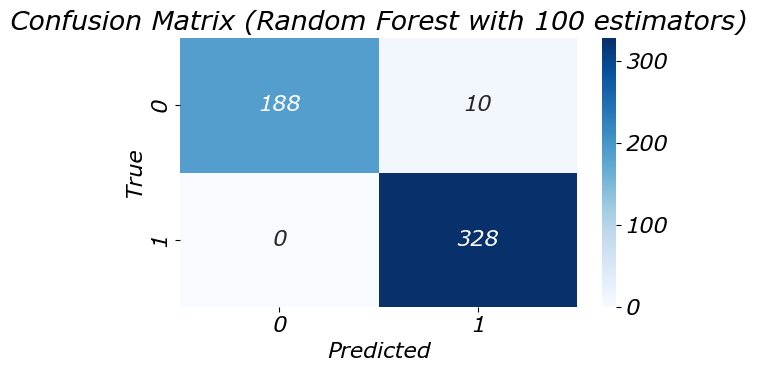

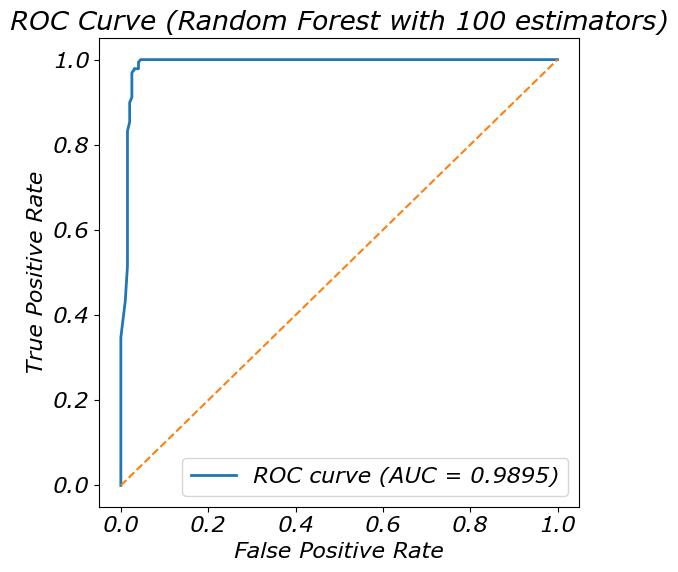

In [28]:
# Stratified 10‑fold CV – 100 estimators
n_estimators = 100

model = RandomForestClassifier(n_estimators=n_estimators,random_state=42)
title = "Random Forest with 100 estimators"
rf100 = train_test_model(model,X_train, y_train, X_test, y_test,title)

#### **8.1.3. Random Forest with 125**

##### **Architecture:**


---

The 125-tree Random Forest further increases the ensemble size to 125 trees while maintaining default hyperparameters (bootstrap=True, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt'). This model tends to achieve the best accuracy or AUC, benefiting from even lower variance at the cost of higher computational and storage demands. Prediction still involves averaging class probabilities across all trees to determine the final output.


Fold 1
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.99      1.00      0.99        76

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123

Accuracy : 0.9919
AUC      : 0.9994
Precision: 0.9870
Recall   : 1.0000
F1       : 0.9935
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        46
           1       0.96      1.00      0.98        77

    accuracy                           0.98       123
   macro avg       0.98      0.97      0.97       123
weighted avg       0.98      0.98      0.98       123

Accuracy : 0.9756
AUC      : 0.9958
Precision: 0.9625
Recall   : 1.0000
F1       : 0.9809
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

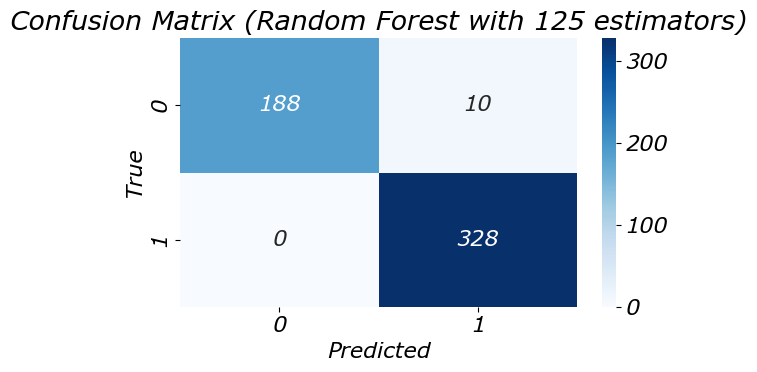

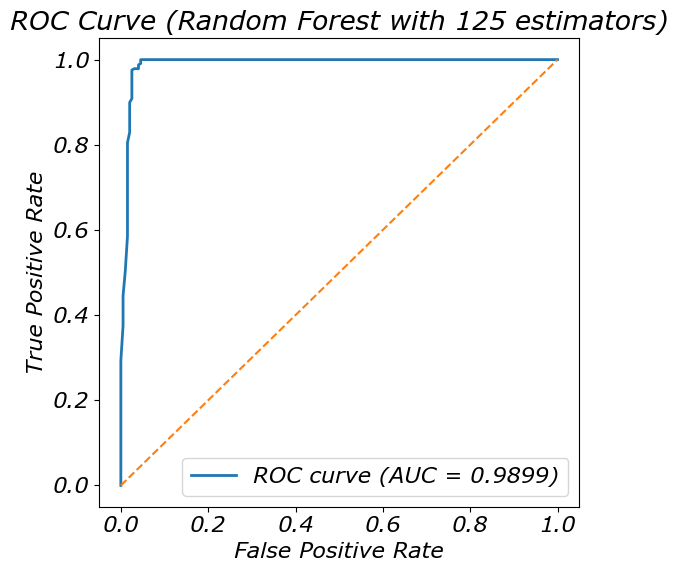

In [29]:
# Stratified 10‑fold CV – 125 estimators
n_estimators = 125

model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
title = "Random Forest with 125 estimators"
rf125 = train_test_model(model,X_train, y_train, X_test, y_test,title)


#### **8.2. MLP**

#### **8.2.1 FFBP1**

In [30]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense
from matplotlib.ticker import ScalarFormatter, MaxNLocator, FuncFormatter
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)

# F1 metric for Keras
def f1_metric(y_true, y_pred):
    y_pred_bin = K.round(y_pred)
    tp = K.sum(K.cast(y_true[:,1] * y_pred_bin[:,1], 'float'))
    fp = K.sum(K.cast((1 - y_true[:,1]) * y_pred_bin[:,1], 'float'))
    fn = K.sum(K.cast(y_true[:,1] * (1 - y_pred_bin[:,1]), 'float'))
    precision = tp / (tp + fp + K.epsilon())
    recall    = tp / (tp + fn + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# Apply a clean Seaborn style
sns.set_theme(style="whitegrid", font_scale=1.1)

def create_mlp_model(input_dim):
    model = Sequential([
        Dense(2 * input_dim, input_dim=input_dim, activation='relu'),
        Dense(input_dim, activation='relu'),
        Dense(2, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[f1_metric]
    )
    return model

def create_mlp2_model(input_dim):
    hidden1 = max(1, int(0.5 * input_dim))
    model = Sequential([
        Dense(hidden1, input_dim=input_dim, activation='relu'),
        Dense(input_dim, activation='relu'),
        Dense(2, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[f1_metric]
    )
    return model

def create_mlp3_model(input_dim):
    hidden1 = max(1, int(0.5 * input_dim))
    hidden2 = max(1, int(0.5 * hidden1))
    model = Sequential([
        Dense(hidden1, input_dim=input_dim, activation='relu'),
        Dense(hidden2, activation='relu'),
        Dense(2, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[f1_metric]
    )
    return model

def smooth_curve(values, factor=0.8):
    smoothed = []
    for v in values:
        if not smoothed:
            smoothed.append(v)
        else:
            smoothed.append(smoothed[-1] * factor + v * (1 - factor))
    return smoothed


def train_test_model_mlp(model_fn, X_train, y_train, X_test, y_test,
                         epochs, batch_size, title):
    # One-hot encode labels
    y_train_cat = to_categorical(y_train, num_classes=2)
    y_test_cat  = to_categorical(y_test,  num_classes=2)

    # --- 10-Fold cross-validation ---
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    for fold_no, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
        model = model_fn(X_train.shape[1])
        history = model.fit(
            X_train[train_idx], y_train_cat[train_idx],
            validation_data=(X_train[val_idx], y_train_cat[val_idx]),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[EarlyStopping('val_loss', patience=20, restore_best_weights=True)],
            verbose=0
        )
        prob = model.predict(X_train[val_idx], verbose=0)
        pred = prob.argmax(axis=1)
        true = y_train_cat[val_idx].argmax(axis=1)
        fold_metrics.append({
            "Fold": fold_no,
            "Accuracy": accuracy_score(true, pred),
            "AUC": roc_auc_score(true, prob[:,1]),
            "Precision": precision_score(true, pred),
            "Recall": recall_score(true, pred),
            "F1": f1_score(true, pred)
        })

    df_folds = pd.DataFrame(fold_metrics)
    print("Metrics by fold:\n", df_folds)
    print("\nAverage ± Std:\n", df_folds.describe().loc[['mean','std']])

    # --- Final training on full train set (30% val split) ---
    final_model = model_fn(X_train.shape[1])
    hist = final_model.fit(
        X_train, y_train_cat,
        validation_split=0.3,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping('val_loss', patience=20, restore_best_weights=True)],
        verbose=0
    )

    # --- Evaluate on test set ---
    y_prob_test = final_model.predict(X_test, verbose=0)
    y_pred      = y_prob_test.argmax(axis=1)

    test_metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob_test[:,1]),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }

    df_test = pd.DataFrame([test_metrics])
    print("\nTest Set Metrics:\n")
    print(df_test.to_string(index=False))

    print("\nClassification report on test set:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Improved Loss Curve Plot ---
    plt.rcParams['font.family'] = 'Verdana'
    plt.rcParams['font.size']   = 16

    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_sm   = smooth_curve(train_loss)
    val_sm     = smooth_curve(val_loss)

    best_epoch = int(np.argmin(val_loss)) + 1
    best_val   = val_loss[best_epoch - 1]

    plt.figure(figsize=(8,5))
    ax = plt.gca()
    epochs_arr = np.arange(1, len(train_loss) + 1)

    ax.plot(epochs_arr, train_sm, label='Train Loss', linewidth=2)
    ax.plot(epochs_arr, val_sm,   label='Val Loss', linestyle='--', linewidth=2)

    ax.axvline(best_epoch, linestyle=':', alpha=0.7, label=f'Best Epoch ({best_epoch})')
    ax.scatter(best_epoch, best_val, s=80, color='red', zorder=5)
    ax.text(best_epoch + 1, best_val, f'{best_val:.4f}',
            va='bottom', ha='left', fontsize=14,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8))

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style='plain', axis='y')

    ax.set_xlabel('Epochs', fontsize=16, fontfamily='Verdana')
    ax.set_ylabel('Loss',   fontsize=16, fontfamily='Verdana')
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.legend(
        loc='upper right',
        prop={'family': 'Verdana', 'size': 14},
        frameon=False
    )

    plt.tight_layout()
    plt.show()

    return final_model, df_folds


##### **Architecture:**


---
FFBP1 is a fully connected neural network architecture composed of two hidden layers, designed to process input vectors whose dimensionality matches that of the feature space. The first hidden layer consists of twice as many neurons as the input dimension, thereby allowing for an initial expansion in representational capacity. The second hidden layer reverts to a neuron count equal to the input dimensionality, potentially refining the feature representation. Both layers employ the Rectified Linear Unit (ReLU) as the activation function, facilitating non-linear transformations while maintaining computational efficiency. The network concludes with a sigmoid-activated output layer comprising two units, which produces normalized class probabilities for binary classification. Training is conducted using the Adam optimization algorithm with a learning rate of 1e-4, minimizing the binary crossentropy loss function.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Metrics by fold:
    Fold  Accuracy       AUC  Precision    Recall        F1
0     1  0.967480  0.996691   0.948718  1.000000  0.973684
1     2  0.991870  0.985843   0.988095  1.000000  0.994012
2     3  0.975610  0.998562   0.975000  0.987342  0.981132
3     4  0.975610  0.997354   0.975610  0.987654  0.981595
4     5  0.943089  0.986728   0.932432  0.971831  0.951724
5     6  0.975610  0.989444   1.000000  0.960000  0.979592
6     7  0.967213  0.998626   0.985294  0.957143  0.971014
7     8  0.975410  0.978684   0.987805  0.975904  0.981818
8     9  0.991803  0.995581   1.000000  0.985915  0.992908
9    10  0.983607  0.998252   0.975000  1.000000  0.987342

Average ± Std:
          Fold  Accuracy       AUC  Precision    Recall        F1
mean  5.50000  0.974730  0.992577   0.976795  0.982579  0.979482
std   3.02765  0.014052  0.006958   0.021505  0.015941  0.012209


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Test Set Metrics:

 Accuracy      AUC  Precision   Recall       F1
 0.979087 0.987312   0.970326 0.996951 0.983459

Classification report on test set:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       198
           1       0.97      1.00      0.98       328

    accuracy                           0.98       526
   macro avg       0.98      0.97      0.98       526
weighted avg       0.98      0.98      0.98       526



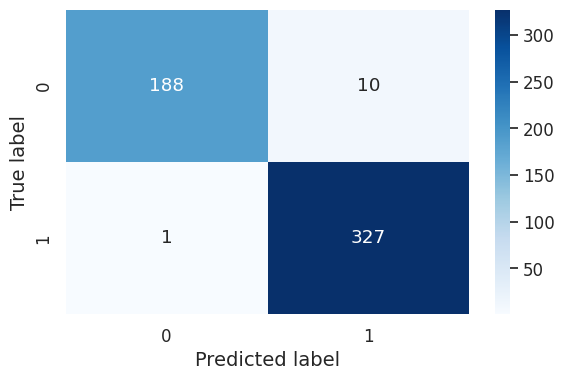

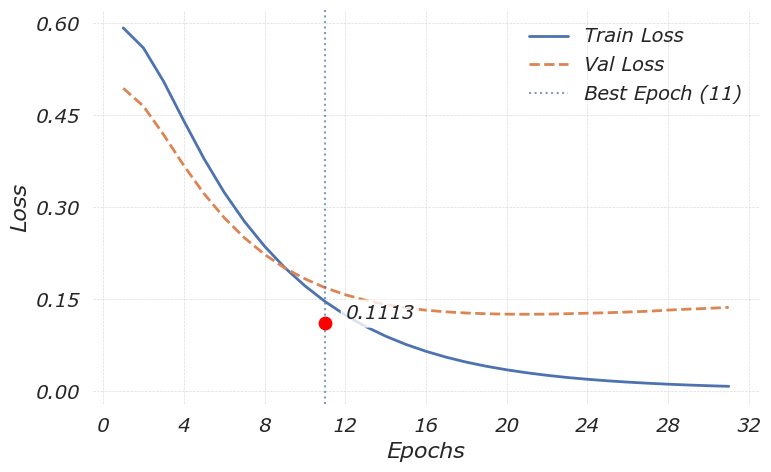

In [31]:
FFBP1_model, FFBP1_metrics = train_test_model_mlp(
    create_mlp_model,
    X_train, y_train,
    X_test,  y_test,
    epochs=1000,
    batch_size=42,
    title='MLP 1'
)

#### **8.2.2. FFBP2**

##### **Architecture:**


---



FFBP2 maintains the two hidden-layer structure and ReLU activations but adopts a different neuron allocation strategy. Specifically, the first hidden layer is composed of half the number of neurons relative to the input dimensionality, which enforces an early compression of the feature space. The second hidden layer restores the neuron count to match the input dimension, potentially enabling re-expansion and re-integration of learned representations. As in FFBP1, a sigmoid output layer with two units is used to generate probabilistic class predictions. Model training follows the same optimization scheme: Adam with a fixed learning rate of 1e-4 and binary crossentropy as the objective function.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Metrics by fold:
    Fold  Accuracy       AUC  Precision    Recall        F1
0     1  0.967480  0.995587   0.948718  1.000000  0.973684
1     2  0.991870  0.985843   0.988095  1.000000  0.994012
2     3  0.975610  0.998849   0.975000  0.987342  0.981132
3     4  0.975610  0.997061   0.975610  0.987654  0.981595
4     5  0.943089  0.978602   0.944444  0.957746  0.951049
5     6  0.975610  0.988056   1.000000  0.960000  0.979592
6     7  0.975410  0.997802   1.000000  0.957143  0.978102
7     8  0.975410  0.980846   0.987805  0.975904  0.981818
8     9  0.991803  0.996134   1.000000  0.985915  0.992908
9    10  0.983607  0.997086   0.975000  1.000000  0.987342

Average ± Std:
          Fold  Accuracy       AUC  Precision    Recall        F1
mean  5.50000  0.975550  0.991587   0.979467  0.981170  0.980123
std   3.02765  0.013801  0.007584   0.020099  0.017538  0.012045


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Test Set Metrics:

 Accuracy      AUC  Precision   Recall       F1
 0.971483 0.988267   0.967164 0.987805 0.977376

Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       198
           1       0.97      0.99      0.98       328

    accuracy                           0.97       526
   macro avg       0.97      0.97      0.97       526
weighted avg       0.97      0.97      0.97       526



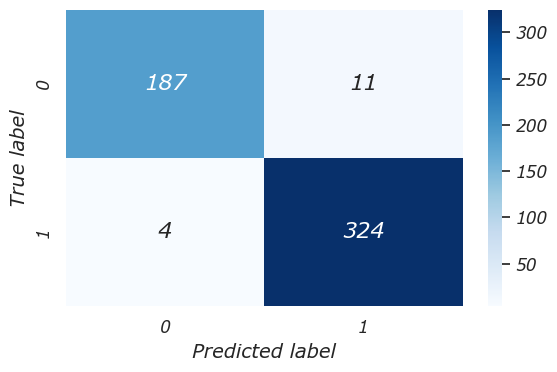

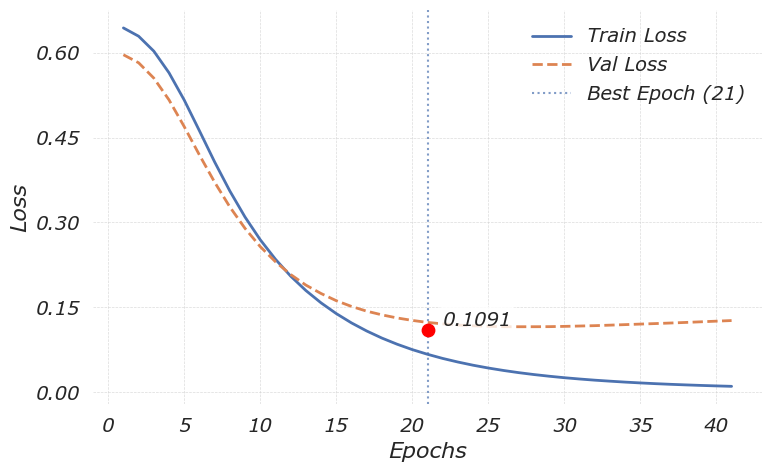

In [32]:
FFBP2_model, FFBP2_metrics = train_test_model_mlp(
    create_mlp2_model,
    X_train, y_train,
    X_test,  y_test,
    epochs=1000,
    batch_size=42,
    title='MLP 2'
)

#### **8.2.3. FFBP3**

##### **Architecture:**


---

FFBP3 introduces a more aggressive reduction strategy across its architecture. The first hidden layer contains half the number of neurons of the input layer, and the second hidden layer further halves that amount, resulting in a significant bottleneck. This compression may encourage the model to extract highly salient features, albeit at the risk of underfitting if the reduction is too severe. ReLU remains the activation function for both layers, preserving consistency across the network family. The model ends with a two-unit sigmoid output layer for binary classification, and is trained identically to the previous models using the Adam optimizer (learning rate = 1e-4) and binary crossentropy loss.

In [ ]:
FFBP3_model, FFBP3_metrics = train_test_model_mlp(
    create_mlp3_model,
    X_train, y_train,
    X_test,  y_test,
    epochs=1000,
    batch_size=42,
    title='MLP 3'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **8.3. SVM**

#### **8.3.1. Linear-Kernel Support Vector Machine (SVM)**

##### **Architecture:**


---

This SVM variant employs a linear kernel, resulting in a decision boundary that takes the form of a single hyperplane in the original feature space. It is particularly well-suited to classification problems where the data are linearly separable or nearly so. The primary hyperparameter is C, which controls the trade-off between achieving a low training error and maintaining a large margin. Models with a higher C place greater emphasis on minimizing classification error, while smaller values favor a simpler decision boundary. Owing to its simplicity and computational efficiency, the linear-kernel SVM is commonly preferred in scenarios requiring interpretable models or rapid training.


Fold 1
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        47
           1       0.99      0.99      0.99        76

    accuracy                           0.98       123
   macro avg       0.98      0.98      0.98       123
weighted avg       0.98      0.98      0.98       123

Accuracy : 0.9837
AUC      : 0.9986
Precision: 0.9868
Recall   : 0.9868
F1       : 0.9868
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        46
           1       0.96      0.99      0.97        77

    accuracy                           0.97       123
   macro avg       0.97      0.96      0.96       123
weighted avg       0.97      0.97      0.97       123

Accuracy : 0.9675
AUC      : 0.9929
Precision: 0.9620
Recall   : 0.9870
F1       : 0.9744
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

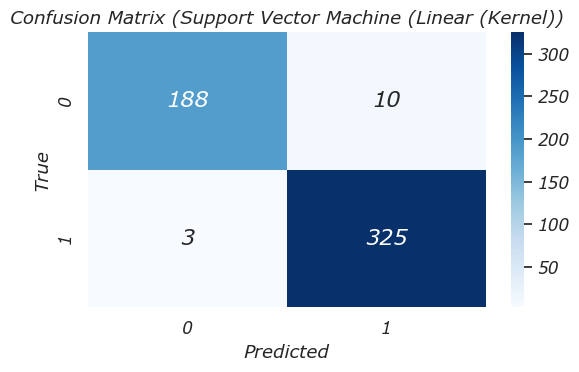

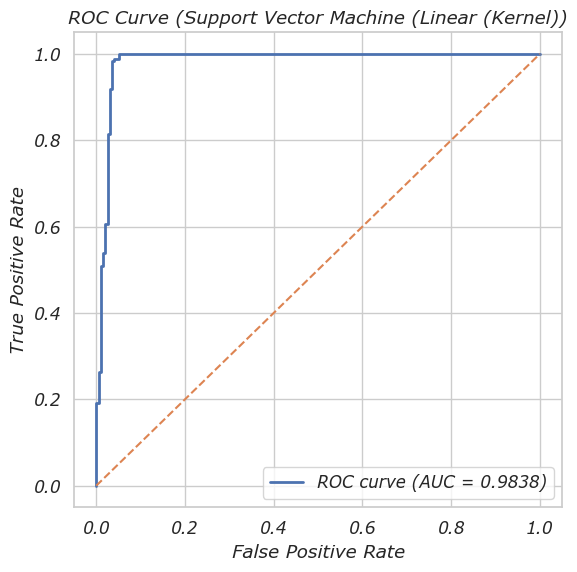

In [47]:

model = SVC(kernel='linear', probability=True, random_state=42)
title = "Support Vector Machine (Linear (Kernel)"
svc_linear = train_test_model(model,X_train, y_train, X_test, y_test,title)


#### **8.3.2. Polynomial-Kernel Support Vector Machine (SVM)**

This variant uses a polynomial kernel function of the form
K(x
,
x
′
)
=
(
γ
x
T
x
′
+
coef0
)
d
K(x,x
′
 )=(γx
T
 x
′
 +coef0)
d
 , enabling the algorithm to fit polynomial decision boundaries in the input space. The model is capable of capturing more complex, non-linear patterns than its linear counterpart by projecting the data into a higher-dimensional space implicitly. Key hyperparameters include:
degree: the degree
d
d of the polynomial function, which determines the model’s flexibility;
gamma: the kernel coefficient that influences the impact of individual training examples;
coef0: the independent term added to the kernel function, which can significantly affect decision boundaries at low degrees.
This kernel is particularly effective when the relationship between input features and output classes is believed to follow a polynomial structure.


Fold 1
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.99      1.00      0.99        76

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123

Accuracy : 0.9919
AUC      : 0.9955
Precision: 0.9870
Recall   : 1.0000
F1       : 0.9935
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        46
           1       0.94      0.99      0.96        77

    accuracy                           0.95       123
   macro avg       0.96      0.94      0.95       123
weighted avg       0.95      0.95      0.95       123

Accuracy : 0.9512
AUC      : 0.9918
Precision: 0.9383
Recall   : 0.9870
F1       : 0.9620
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

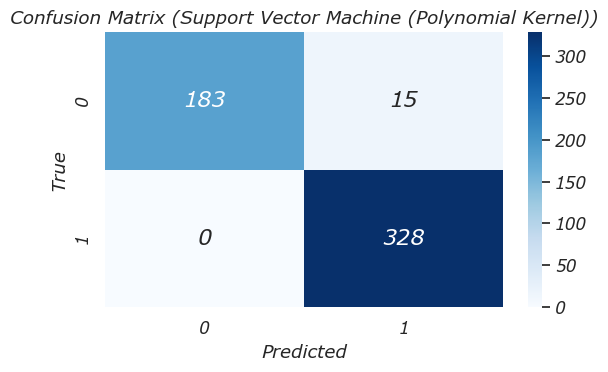

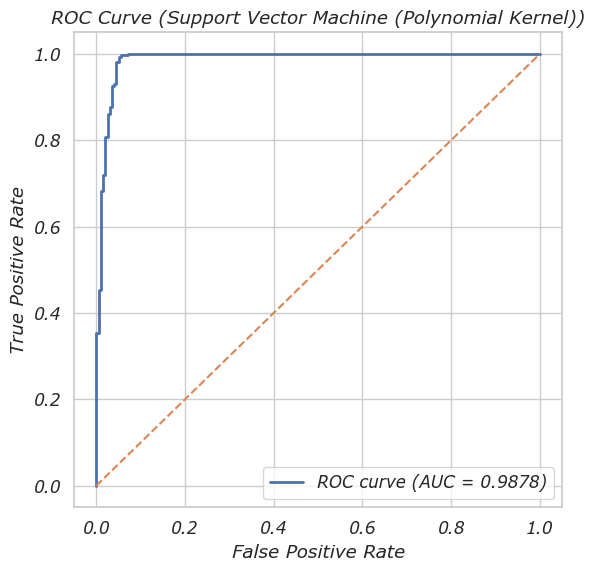

In [45]:

model = SVC(kernel='poly', probability=True, random_state=42)
title = "Support Vector Machine (Polynomial Kernel)"
svc_poly = train_test_model(model,X_train, y_train, X_test, y_test,title)


#### **8.3.3. Radial Basis Function (RBF)-Kernel Support Vector Machine (SVM)**

##### **Architecture:**


---

Also known as the Gaussian kernel SVM, this model maps input data into an infinite-dimensional feature space via a radial basis function kernel defined as
K
(
x
,
x
′
)
=
exp
⁡
(
−
γ
∥
x
−
x
′
∥
2
)
K(x,x
′
 )=exp(−γ∥x−x
′
 ∥
2
 ). The resulting decision boundaries are highly flexible and capable of modeling complex, non-linear separations between classes. The principal hyperparameters are:
gamma: which determines the extent to which a single training example influences the shape of the decision boundary; smaller values produce smoother boundaries, while larger values yield more localized patterns;
C: which governs the regularization strength and controls the balance between margin size and classification accuracy.
The RBF kernel is generally the most powerful among the standard SVM kernels, especially in tasks where class boundaries are highly non-linear or not readily captured by simpler models.


Fold 1
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.99      1.00      0.99        76

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123

Accuracy : 0.9919
AUC      : 0.9927
Precision: 0.9870
Recall   : 1.0000
F1       : 0.9935
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        46
           1       0.95      1.00      0.97        77

    accuracy                           0.97       123
   macro avg       0.98      0.96      0.96       123
weighted avg       0.97      0.97      0.97       123

Accuracy : 0.9675
AUC      : 0.9853
Precision: 0.9506
Recall   : 1.0000
F1       : 0.9747
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

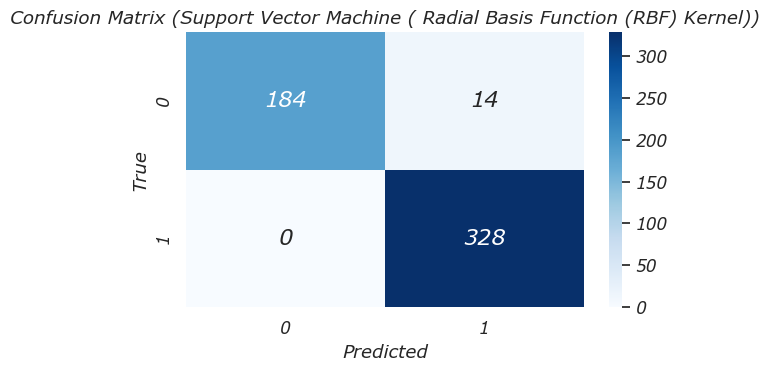

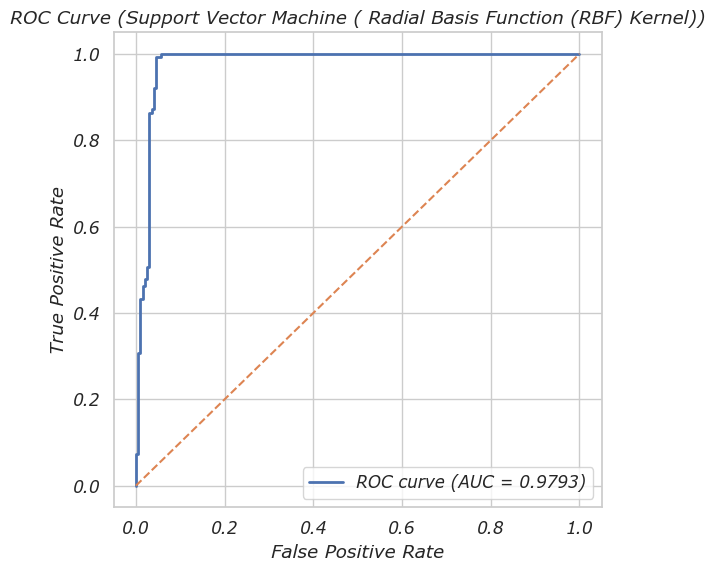

In [46]:

model = SVC(kernel='rbf', probability=True, random_state=42)
title = "Support Vector Machine ( Radial Basis Function (RBF) Kernel)"
svc_rbf = train_test_model(model,X_train, y_train, X_test, y_test,title)


# **8.4. KNN**

#### **8.4.1. KNN (3 Neighbors)**

##### **Architecture:**

---
When
k = 3
k=3, the model considers only the three nearest neighbors, using the standard Euclidean distance metric to determine proximity. Classification is performed via majority voting among these three neighbors. This configuration exhibits low bias, enabling it to capture intricate decision boundaries and fit complex patterns in the data. However, this expressiveness comes at the cost of higher variance, making the model particularly sensitive to noise and outliers.


Fold 1
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        47
           1       0.97      0.91      0.94        76

    accuracy                           0.93       123
   macro avg       0.92      0.93      0.92       123
weighted avg       0.93      0.93      0.93       123

Accuracy : 0.9268
AUC      : 0.9737
Precision: 0.9718
Recall   : 0.9079
F1       : 0.9388
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        46
           1       0.97      0.91      0.94        77

    accuracy                           0.93       123
   macro avg       0.92      0.93      0.92       123
weighted avg       0.93      0.93      0.93       123

Accuracy : 0.9268
AUC      : 0.9613
Precision: 0.9722
Recall   : 0.9091
F1       : 0.9396
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

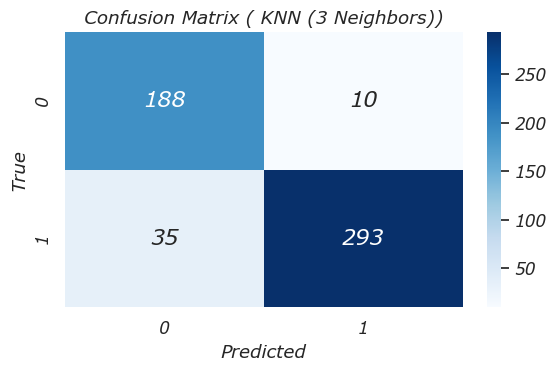

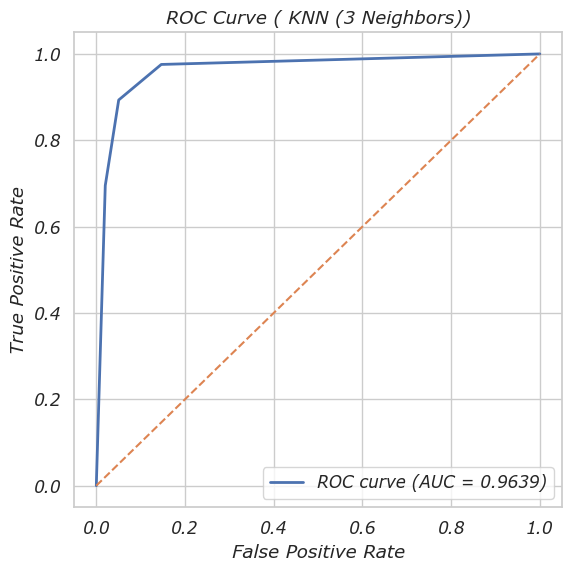

In [48]:

model = KNeighborsClassifier(n_neighbors=3)
title = " KNN (3 Neighbors)"
knn3 = train_test_model(model,X_train, y_train, X_test, y_test,title)


 #### **8.4.2. KNN (5 Neighbors)**

##### **Architecture**



---


In contrast, the
k = 5 configuration represents a more balanced approach. By averaging over a slightly larger neighborhood, it achieves a better bias–variance trade-off. The increased neighbor count makes the model more robust to local fluctuations and noise while still maintaining sufficient flexibility to model moderately complex relationships.


Fold 1
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        47
           1       0.97      0.89      0.93        76

    accuracy                           0.92       123
   macro avg       0.91      0.93      0.92       123
weighted avg       0.92      0.92      0.92       123

Accuracy : 0.9187
AUC      : 0.9880
Precision: 0.9714
Recall   : 0.8947
F1       : 0.9315
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       0.82      0.91      0.87        46
           1       0.94      0.88      0.91        77

    accuracy                           0.89       123
   macro avg       0.88      0.90      0.89       123
weighted avg       0.90      0.89      0.90       123

Accuracy : 0.8943
AUC      : 0.9787
Precision: 0.9444
Recall   : 0.8831
F1       : 0.9128
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

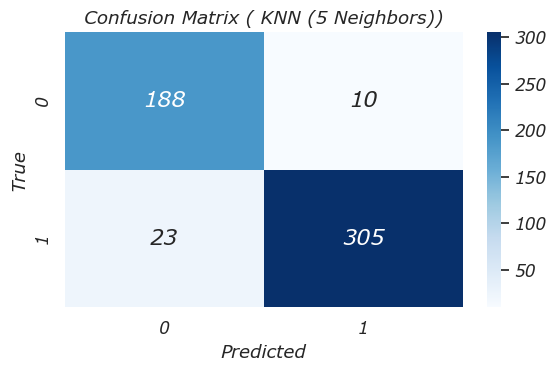

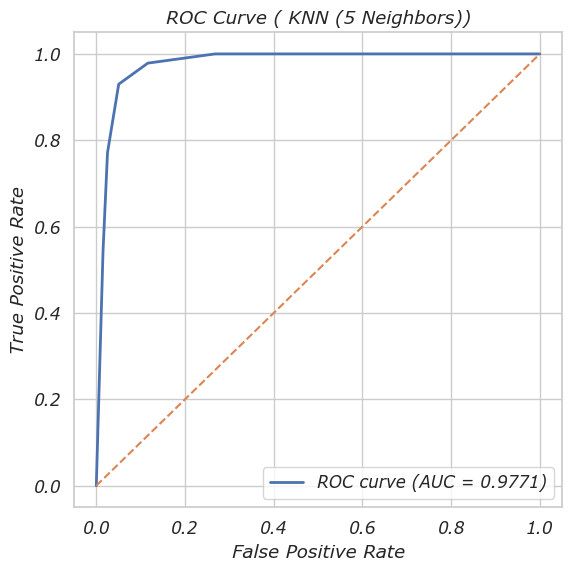

In [49]:

model = KNeighborsClassifier(n_neighbors=5)
title = " KNN (5 Neighbors)"
knn5 = train_test_model(model,X_train, y_train, X_test, y_test,title)


#### **8.4.3. KNN (7 Neighbors)**

##### **Architecture:**


---
With
k = 7, the algorithm leans further toward stability and generalization. Using a larger set of nearest neighbors tends to smooth the decision boundary, thereby increasing bias while simultaneously reducing variance. This configuration is more resistant to overfitting and produces more consistent predictions across different datasets. However, its higher bias may result in underfitting, particularly in scenarios where class boundaries are highly non-linear or intricate.


Fold 1
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        47
           1       0.97      0.95      0.96        76

    accuracy                           0.95       123
   macro avg       0.95      0.95      0.95       123
weighted avg       0.95      0.95      0.95       123

Accuracy : 0.9512
AUC      : 0.9913
Precision: 0.9730
Recall   : 0.9474
F1       : 0.9600
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        46
           1       0.95      0.91      0.93        77

    accuracy                           0.91       123
   macro avg       0.90      0.91      0.91       123
weighted avg       0.91      0.91      0.91       123

Accuracy : 0.9106
AUC      : 0.9773
Precision: 0.9459
Recall   : 0.9091
F1       : 0.9272
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

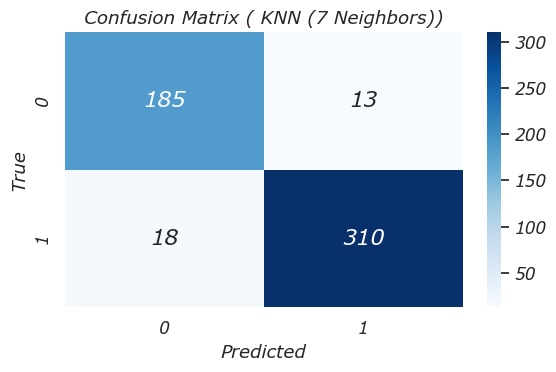

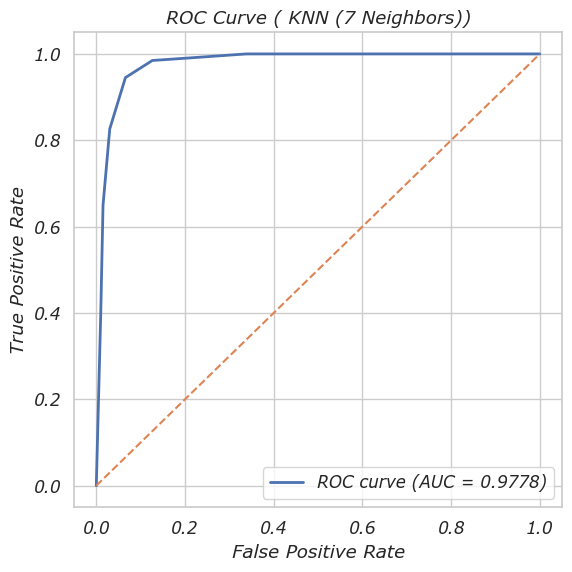

In [50]:

model = KNeighborsClassifier(n_neighbors=7)
title = " KNN (7 Neighbors)"
knn7 = train_test_model(model,X_train, y_train, X_test, y_test,title)


# **8.4.5. Naive Bayes**

##### **Architecture**


---

The Gaussian Naive Bayes classifier is a generative probabilistic model grounded in Bayes’ theorem, operating under the simplifying assumption that all features are conditionally independent given the class label. This "naive" independence assumption significantly reduces computational complexity and facilitates efficient parameter estimation. During the training phase, the model computes the prior probability of each class based on its relative frequency in the dataset. Simultaneously, it estimates the parameters (mean and variance) of a Gaussian distribution for each feature, conditional on each class.
During inference, the model evaluates the likelihood of a given test instance under each class by assuming that the features follow class-specific univariate Gaussian distributions. These likelihoods are then multiplied by the corresponding class priors to produce unnormalized posterior probabilities. The predicted label corresponds to the class with the highest posterior probability.
Despite its algorithmic simplicity and the strong independence assumption, the Gaussian Naive Bayes classifier often yields robust and computationally efficient performance, particularly in scenarios where feature distributions are approximately normal and exhibit low interdependence.


Fold 1
              precision    recall  f1-score   support

           0       0.65      0.96      0.78        47
           1       0.96      0.68      0.80        76

    accuracy                           0.79       123
   macro avg       0.81      0.82      0.79       123
weighted avg       0.84      0.79      0.79       123

Accuracy : 0.7886
AUC      : 0.8208
Precision: 0.9630
Recall   : 0.6842
F1       : 0.8000
--------------------------------------------------

Fold 2
              precision    recall  f1-score   support

           0       0.68      0.98      0.80        46
           1       0.98      0.73      0.84        77

    accuracy                           0.82       123
   macro avg       0.83      0.85      0.82       123
weighted avg       0.87      0.82      0.82       123

Accuracy : 0.8211
AUC      : 0.8528
Precision: 0.9825
Recall   : 0.7273
F1       : 0.8358
--------------------------------------------------

Fold 3
              precision    recall  f1-sc

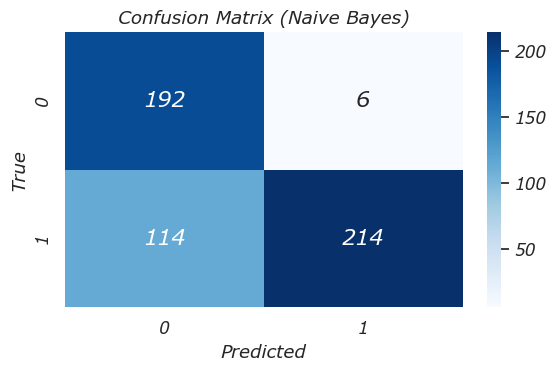

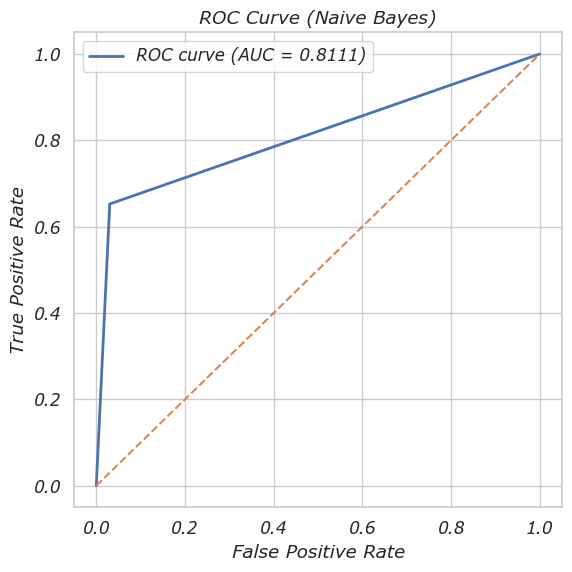

In [51]:

model = GaussianNB()
title = "Naive Bayes"
gnb= train_test_model(model,X_train, y_train, X_test, y_test,title)


## **9. Wilcoxon Test**

In [ ]:
pip install scipy


In [52]:
import pandas as pd
from scipy.stats import wilcoxon

# F1 scores for each model across 10 folds
data = {
    "RF_75":   rf75['fold_f1'],
    "RF_100":  rf100['fold_f1'],
    "RF_125":  rf125['fold_f1'],
    "FFBP1":  FFBP1_metrics['F1'].values,
    "FFBP2":  FFBP2_metrics['F1'].values,
    "FFBP3":  FFBP3_metrics['F1'].values,
    "SVM_Lin": svc_linear['fold_f1'],
    "SVM_Pol": svc_poly['fold_f1'],
    "SVM_Rad": svc_rbf['fold_f1'],
    "KNN_3":   knn3['fold_f1'],
    "KNN_5":   knn5['fold_f1'],
    "KNN_7":   knn7['fold_f1'],
    "NB":      gnb['fold_f1'],
}

# Create DataFrame
dataFrame = pd.DataFrame(data)

# Pivot series
pivot = dataFrame["FFBP1"]

# Perform Wilcoxon signed‐rank test against all other models
p_values = {}
for model in dataFrame.columns:
    if model == "FFBP1":
        continue
    stat, p = wilcoxon(pivot, dataFrame[model])
    p_values[model] = p

# Print the p‐values
for model, p in p_values.items():
    print(f"Wilcoxon test FFBP1 vs {model}: p‐value = {p:.4f}")


Wilcoxon test FFBP1 vs RF_75: p‐value = 0.5566
Wilcoxon test FFBP1 vs RF_100: p‐value = 0.5566
Wilcoxon test FFBP1 vs RF_125: p‐value = 0.7695
Wilcoxon test FFBP1 vs FFBP2: p‐value = 1.0000
Wilcoxon test FFBP1 vs FFBP3: p‐value = 0.7500
Wilcoxon test FFBP1 vs SVM_Lin: p‐value = 0.6953
Wilcoxon test FFBP1 vs SVM_Pol: p‐value = 0.4316
Wilcoxon test FFBP1 vs SVM_Rad: p‐value = 0.4922
Wilcoxon test FFBP1 vs KNN_3: p‐value = 0.0020
Wilcoxon test FFBP1 vs KNN_5: p‐value = 0.0020
Wilcoxon test FFBP1 vs KNN_7: p‐value = 0.0020
Wilcoxon test FFBP1 vs NB: p‐value = 0.0020


Evaluation of models

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Final classification report on test:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       198
           1       0.97      0.99      0.98       328

    accuracy                           0.97       526
   macro avg       0.97      0.97      0.97       526
weighted avg       0.97      0.97      0.97       526

Confusion Matrix:
[[187  11]
 [  4 324]]


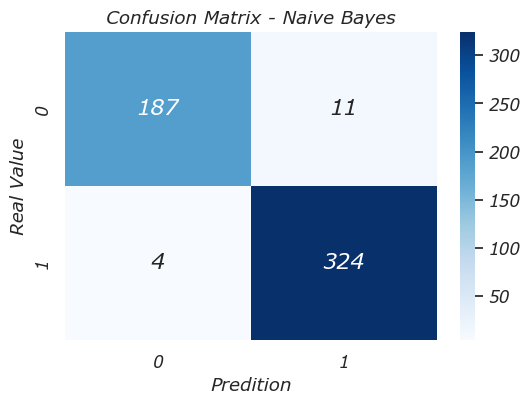

In [53]:
y_pred = np.argmax(FFBP2_model.predict(X_test), axis=1)
y_true = y_test

print("\nFinal classification report on test:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predition')
plt.ylabel('Real Value')
plt.title(f'Confusion Matrix - {title}')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Final classification report on test:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       198
           1       0.97      0.99      0.98       328

    accuracy                           0.98       526
   macro avg       0.98      0.97      0.97       526
weighted avg       0.98      0.98      0.98       526

Confusion Matrix:
[[188  10]
 [  3 325]]


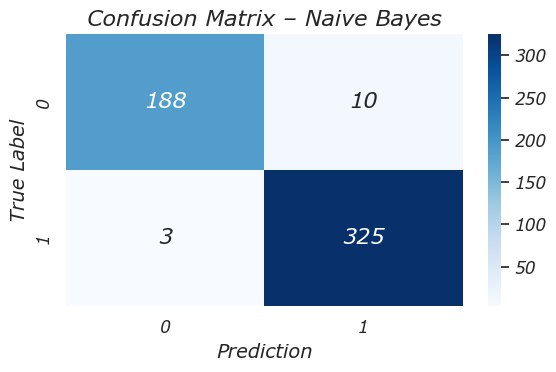

In [54]:
y_prob = FFBP3_model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = y_test

print("\nFinal classification report on test:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title(f'Confusion Matrix – {title}', fontsize=16)
plt.tight_layout()
plt.show()


## **10. Conclusions & Future Work**

The FFBP2 model emerged as the best-performing classifier, demonstrating superior generalization capabilities and consistent results across both training and test phases. It achieved an F1-score of 0.977 on the training set and 0.981 on the test set, indicating minimal overfitting and robust pattern recognition from the biomechanical data. This performance highlights its effectiveness in distinguishing injured from non-injured subjects, surpassing traditional models such as RF and SVM in both accuracy and stability. Overall, the proposed method establishes a reliable foundation for sports injury classification with high precision and recall.
Future work will focus on expanding the dataset to improve model generalizability across various athlete profiles and injury types. We also plan to evaluate more complex deep learning architectures, including convolutional and recurrent networks. Integrating real-time data acquisition systems is another goal to support live monitoring. Additionally, enhancing methodological transparency in preprocessing and feature engineering will be prioritized for reproducibility.
